# Image Stiching

The goal of this notebook is to go over several important concepts in image processing :
- Detect characteristic points in images (also known as keypoints or points of interest).
- Describe these keypoints.
- Match keypoints between two images.
- Compute the homography between two images.
- Stitch the two images together to create a panorama.

The workflow involves:
1. Loading two images (a "left" image – L, and a "right" image – R).
2. Detecting a set of keypoints, $F_P^l$ and $F_P^r$, in each image using an OpenCV detector.
3. Computing descriptor vectors, $F_D^l$ and $F_D^r$, for each of the keypoints in $F_P^l$ and $F_P^r$, respectively.
4. Matching the descriptor vectors $F_D^l$ and $F_D^r$ to establish correspondence between keypoints of the left and right images.
5. Calculating the geometric transformation (homography) that maps points from the left image to the right image.
6. Applying this homography to the right image to obtain $R_H$.
7. Stitching the transformed right image, $R_H$, alongside the left image, L.

Let's start by importing the necessary libraries and defining some helper functions.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Define the directory where images are stored
IMAGE_DIR = "images"

# Optionally, you can create the directory if it doesn't exist
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

def test_load_image(img):
    """
    Tests if an image has been loaded successfully.

    Args:
        img (numpy.ndarray): Image to be tested.

    Raises:
        SystemExit: If the image cannot be loaded.
    """
    if img is None or img.size == 0 or (img.shape[0] == 0) or (img.shape[1] == 0):
        print("Could not load image!")
        print("Exiting now...")
        exit(1)


def load_gray_image(filename):
    """
    Loads an image from the IMAGE_DIR and converts it to grayscale.

    Args:
        filename (str): Name of the image file.

    Returns:
        tuple: Original image and its grayscale version. Returns (None, None) if filename is None.
    """
    if filename is not None:
        path = os.path.join(IMAGE_DIR, filename)
        img = cv.imread(path)
        test_load_image(img)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        img = None
        gray = None
    return img, gray


def display_image(img, title="Image"):
    """
    Displays an image using matplotlib with adjustable figure size.

    Args:
        img (numpy.ndarray): Image to be displayed.
        title (str, optional): Title of the image display. Defaults to "Image".
    """
    if img is not None:
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))  
        plt.imshow(img_rgb)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("No image to display.")

## Detecting Keypoints

Detecting points of interest (or zones of interest) in computer vision involves algorithmically identifying significant points or areas within an image. These "interesting" points are crucial for characterizing an image, as they possess distinctive properties that facilitate various image processing tasks.

Numerous methods exist for detecting such points or zones, and presenting all of them is beyond the scope of this document. In essence, a feature detector takes an image as input and outputs a set of pixel coordinates representing the identified points of interest based on the detector's specific method.

It's important to note that a feature detector solely provides the coordinates of these points and does not supply additional information.

In this notebook, we will go over the following feature detectors:
- **SIFT**: Detects and describes keypoints with high accuracy. It is robust to scale and rotation but is slower due to its complexity.
- **ORB**: Detects and describes keypoints quickly and efficiently. It is suitable for real-time applications.




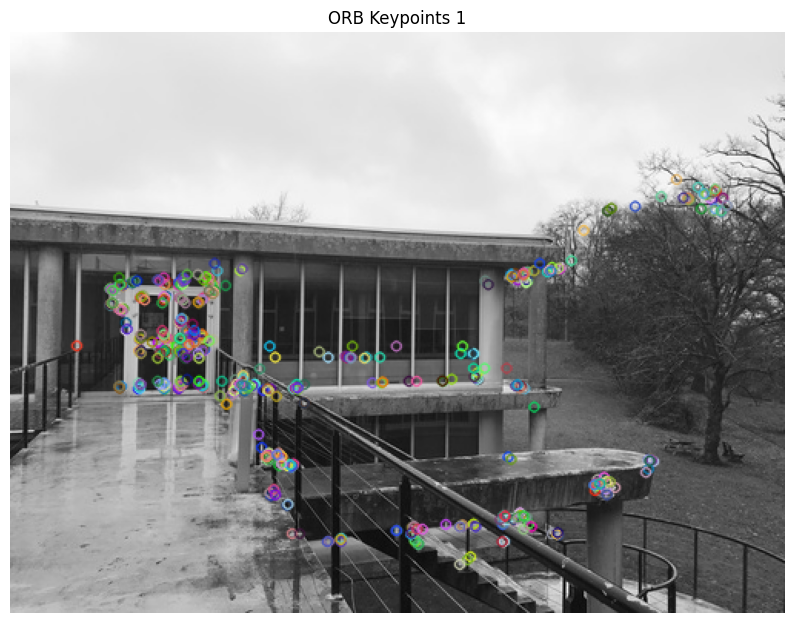

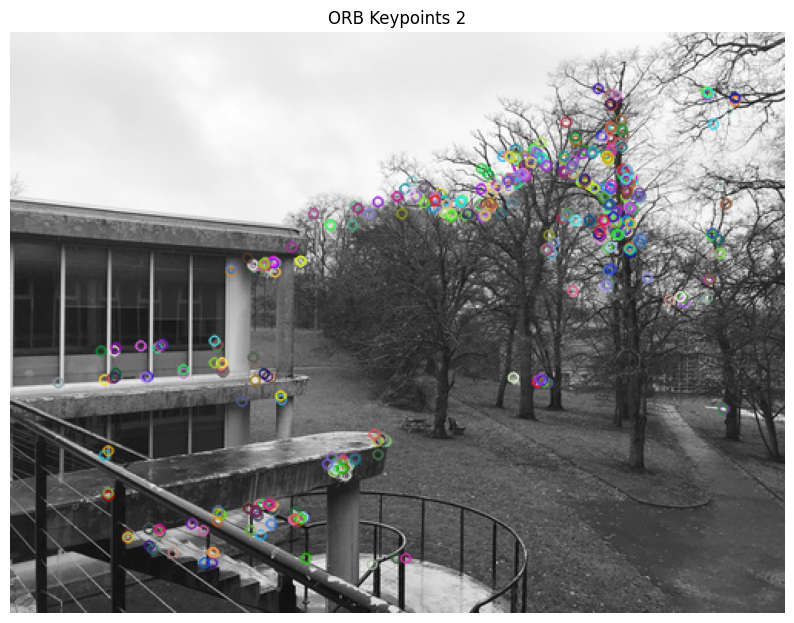

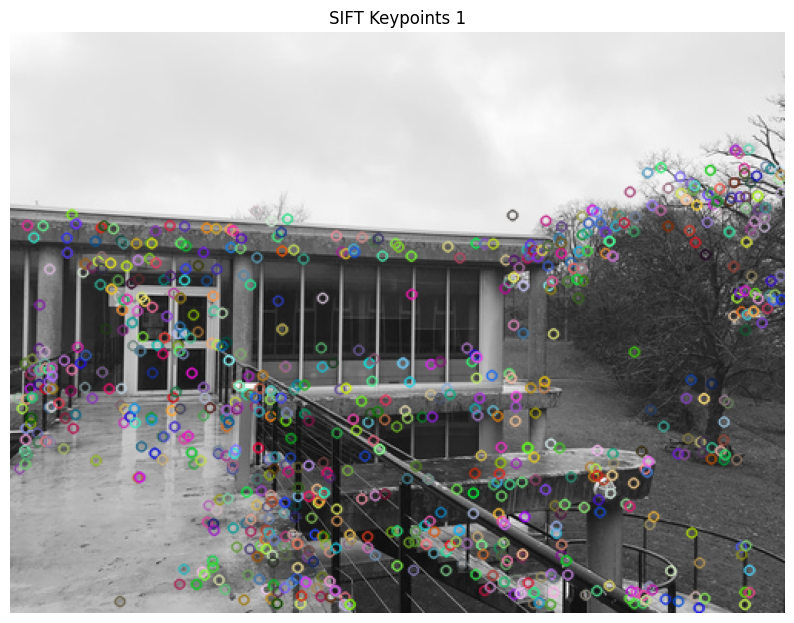

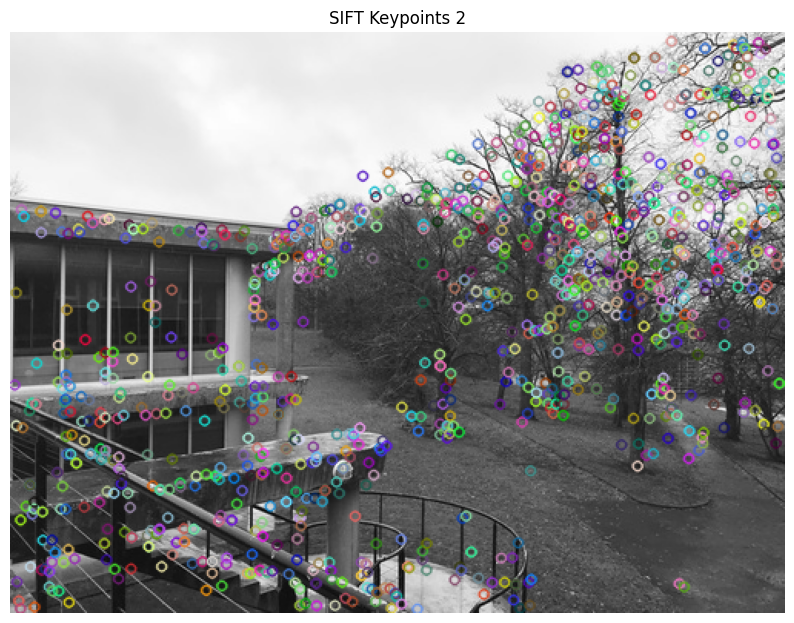

In [3]:
def detect_keypoints(gray, detector, nbKp):
    """
    Detects keypoints in an image using a specified detector.

    Args:
        gray (numpy.ndarray): Grayscale image.
        detector (str): Type of detector to be used.
        nbKp (int): Number of keypoints to be detected
            - SIFT: It defaults to 0 in order to detect all keypoints
            - ORB: It defaults to 500 keypoints which balances speed and accuracy

    Returns:
        tuple: Detected keypoints and the detector object.
    """
    if gray is not None:
        if detector == "SIFT":
            sift = cv.SIFT_create(nfeatures=nbKp if nbKp is not None else 0) 
            kp = sift.detect(gray, None)
            detector_obj = sift
        elif detector == "ORB":
            orb = cv.ORB_create(nfeatures=nbKp if nbKp is not None else 500)
            kp = orb.detect(gray, None)
            detector_obj = orb
        else:
            print("Invalid keypoint detector!")
            print("Exiting now...")
            exit(1)
    else:
        kp = None
        detector_obj = None
    return kp, detector_obj

# Load the first image
img1, gray1 = load_gray_image("Image_1.jpg")

# Load the second image
img2, gray2 = load_gray_image("Image_2.jpg")

# Detect ORB keypoints
orb_kp_1, orb_detector_1 = detect_keypoints(gray1, detector="ORB", nbKp=500)
orb_kp_2, orb_detector_2 = detect_keypoints(gray2, detector="ORB", nbKp=500)
img1_orb = cv.drawKeypoints(gray1, orb_kp_1, None)
img2_orb = cv.drawKeypoints(gray2, orb_kp_2, None)
display_image(img1_orb, "ORB Keypoints 1")
display_image(img2_orb, "ORB Keypoints 2")

# Detect SIFT keypoints
sift_kp_1, sift_detector_1 = detect_keypoints(gray1, detector="SIFT", nbKp=0)
sift_kp_2, sift_detector_2 = detect_keypoints(gray2, detector="SIFT", nbKp=0)
img1_sift = cv.drawKeypoints(gray1, sift_kp_1, None)
img2_sift = cv.drawKeypoints(gray2, sift_kp_2, None)
display_image(img1_sift, "SIFT Keypoints 1")
display_image(img2_sift, "SIFT Keypoints 2")

Both **SIFT** and **ORB** detectors have successfully identified keypoints on the left and right images. The next step is to compute the descriptors for these keypoints.


## Describing Keypoints

A feature descriptor is an algorithm designed to characterize points of interest within an image. It takes an image and a set of points of interest as input and produces a descriptor vector for each point. These descriptors encode unique characteristics of each point, effectively creating a signature that distinguishes them from one another.

Feature descriptors rely not only on the list of points of interest but also on the image itself, as they often utilize information from the surrounding area of each point, such as color gradients and intensity gradients. Additionally, they typically incorporate the scale associated with each point of interest, since changes in image scale can significantly affect point detection and descriptions.

Ideally, a feature descriptor possesses several key properties, including:
- **Invariance to rotation**
- **Invariance to scaling**
- **Invariance to geometric transformations**

These properties enable the identification of the same point of interest even when the image has undergone transformations. For example, a point in an image should be recognized as identical even if the image is rotated by 45°.

Let's compute the descriptors for the keypoints detected in the left and right images using the SIFT and ORB descriptors.

In [4]:
def compute_descriptors(gray, keypoints, detector):
    """
    Computes descriptors for the detected keypoints using the given detector.

    Args:
        gray (numpy.ndarray): Grayscale image.
        keypoints (list): Detected keypoints.
        detector (cv2.DescriptorExtractor): Detector object with compute method.

    Returns:
        numpy.ndarray: Descriptor array.
    """
    if gray is not None and keypoints is not None and detector is not None:
        _, descriptors = detector.compute(gray, keypoints)
    else:
        descriptors = None
    return descriptors

# Compute descriptors for ORB keypoints
orb_descriptors_1 = compute_descriptors(gray1, orb_kp_1, orb_detector_1)
orb_descriptors_2 = compute_descriptors(gray2, orb_kp_2, orb_detector_2)

# Compute descriptors for SIFT keypoints
sift_descriptors_1 = compute_descriptors(gray1, sift_kp_1, sift_detector_1)
sift_descriptors_2 = compute_descriptors(gray2, sift_kp_2, sift_detector_2)

Now that we have detected and described the keypoints in both images, we can proceed to match these keypoints to establish correspondence between the left and right images.

## Matching Keypoints

Feature matching essentially addresses the following question:
"Given two images, I₁ and I₂, how can we identify the corresponding features between them?"

The approach to answer this involves:

1. **Defining a Distance Function**: Compare the descriptors of various features using a specific distance metric.
2. **Evaluating Features in I₂**: Test all features in I₂ to find those with the minimum distance based on the defined function.

Several functions can be used to calculate the matching between two sets of descriptors:

- **SSD**: *Sum of Squared Differences* between the two descriptors
- **Ratio of SSD**
- Distances such as $L_1$, $L_2$, and **Hamming**

Additionally, there are various methods for performing the matching:

- **Brute Force**: Compare all descriptors pairwise, ensuring the best results but at the cost of high computational time.
- **FLANN-based**: Utilizes the *Fast Library for Approximate Nearest Neighbors* to optimize the search by not testing all possible combinations, resulting in much faster performance on large datasets.

After selecting the distance function and matching method, it's crucial to **choose a threshold** to determine when a *matching* is considered reliable. A common approach is to base this threshold on **the minimum distance calculated during the matching**. Typically, the threshold is set by multiplying the minimum distance ($distMin$) by a coefficient ($a$), generally ranging from 3 to 20:

$$
\text{threshold} = a \times distMin
$$

Let's match the keypoints detected in the left and right images using the SIFT and ORB descriptors and visualize the results.

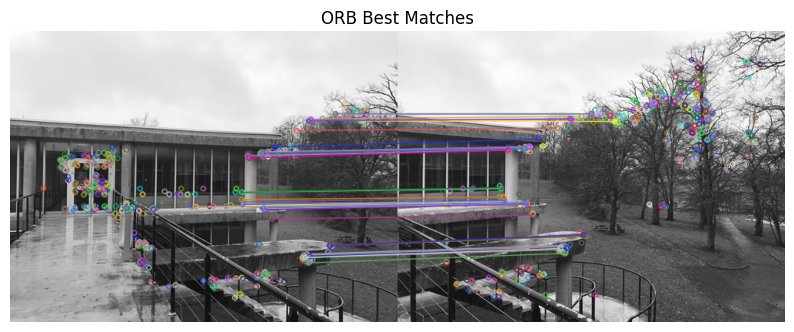

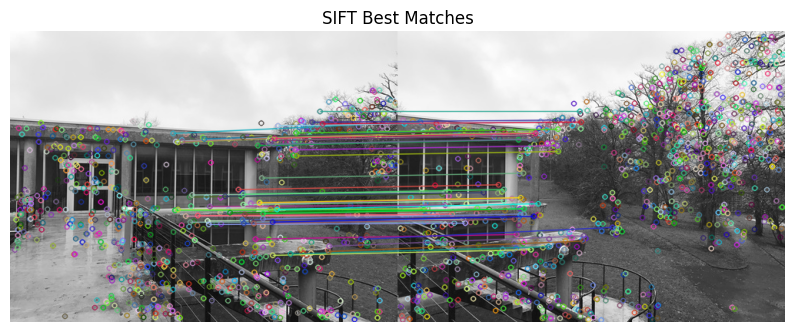

In [5]:
def match_keypoints(matching_type, descriptors1, descriptors2, alpha=3):
    """
    Matches descriptors between two images using brute-force matcher.

    Args:
        matching_type (int): Norm type for BFMatcher (e.g., cv.NORM_L1, cv.NORM_L2, cv.NORM_HAMMING, cv.NORM_HAMMING2).
        descriptors1 (numpy.ndarray): Descriptors from the first image.
        descriptors2 (numpy.ndarray): Descriptors from the second image.
        alpha (float): Multiplier for threshold.

    Returns:
        list: Best matches satisfying the threshold.
    """
    bf = cv.BFMatcher(normType=matching_type, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    min_dist = min(m.distance for m in matches)
    threshold = alpha * min_dist
    bestMatches = [m for m in matches if m.distance < threshold]
    return bestMatches

# Match ORB descriptors
orb_best_matches = match_keypoints(cv.NORM_HAMMING, orb_descriptors_1, orb_descriptors_2)

# Draw and display ORB matches
img_orb_matches = cv.drawMatches(
    img1_orb, orb_kp_1,
    img2_orb, orb_kp_2,
    orb_best_matches,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
display_image(img_orb_matches, "ORB Best Matches")

# Match SIFT descriptors
sift_best_matches = match_keypoints(cv.NORM_L2, sift_descriptors_1, sift_descriptors_2)

# Draw and display SIFT matches
img_sift_matches = cv.drawMatches(
    img1_sift, sift_kp_1,
    img2_sift, sift_kp_2,
    sift_best_matches,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
display_image(img_sift_matches, "SIFT Best Matches")

## Calculating Image Transformation Using Homography

Once the matching process is complete, resulting in two corresponding sets of points, we need to estimate the geometric transformation that connects them. Since these points are coplanar, the appropriate transformation is a homography. 

Using the two sets of points (**"good matches"** $GM_l$ and $GM_r$) we can estimate the $3 \times 3$ homography matrix $H$ as follows:

$$
H = estimateHomography(GM_l, GM_r)
$$

After obtaining the homography matrix $H$, we apply it to the right image and merge it with the left image to create the final stitched panorama.


In [6]:
def compute_homography(kp1, kp2, matches):
    """
    Computes homography matrix using RANSAC (Random Sample Consensus).

    Args:
        kp1 (list): Keypoints from the first image.
        kp2 (list): Keypoints from the second image.
        matches (list): Best matches between the keypoints.

    Returns:
        tuple: Homography matrix and inliers.
    """
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    return H

# Compute homography for ORB matches
orb_H = compute_homography(orb_kp_1, orb_kp_2, orb_best_matches)

# Compute homography for SIFT matches
sift_H = compute_homography(sift_kp_1, sift_kp_2, sift_best_matches)

## Stitching Images

After detecting and matching keypoints using ORB and SIFT detectors, we can proceed to stitch the two images together to create a seamless panorama. This involves the following steps:

1. **Warping the Second Image**: Use the computed homography matrix to warp the second image so that it aligns with the first image.
2. **Creating a Canvas**: Determine the size of the resulting panorama and create a canvas that can accommodate both images.
3. **Blending Images**: Place the first image onto the canvas and overlay the warped second image. Handle any overlapping regions to ensure a smooth transition.
4. **Displaying the Panorama**: Show the final stitched image.

The following code implements these steps for both ORB and SIFT based homographies.

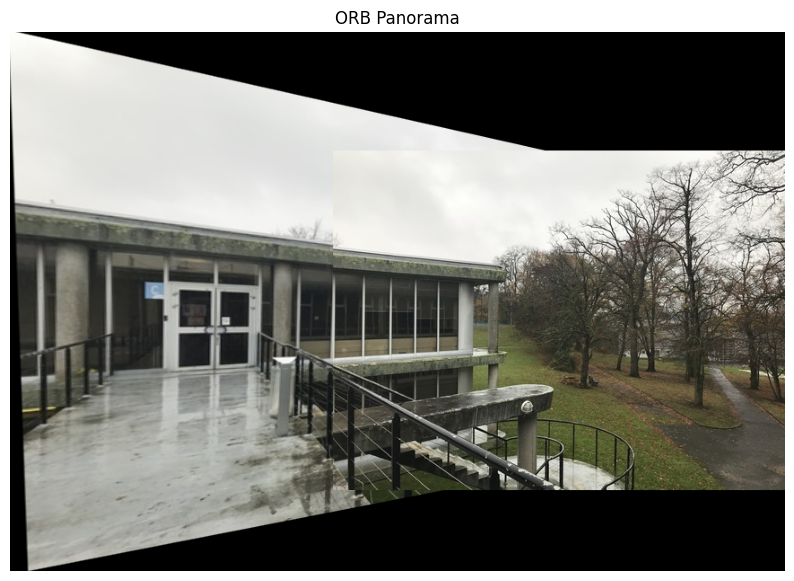

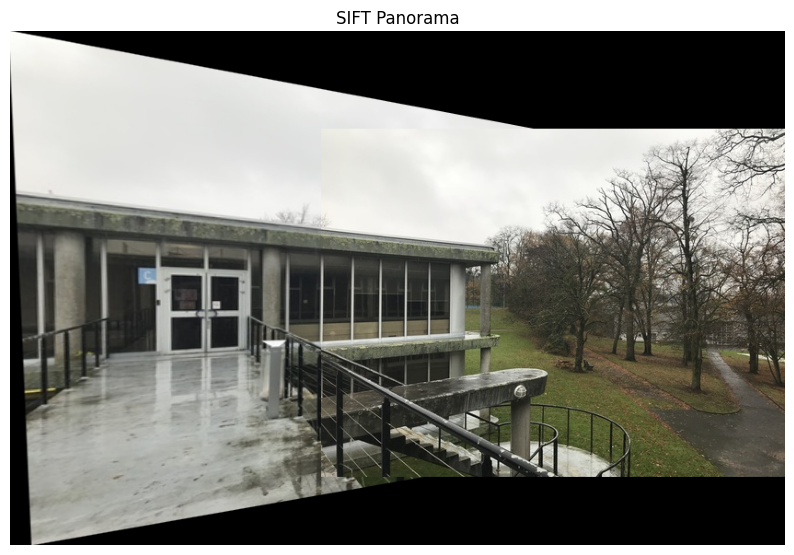

In [7]:
def stitch_images(img1, img2, H):
    """
    Stitches two images using the provided homography matrix.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        H (numpy.ndarray): Homography matrix.

    Returns:
        numpy.ndarray: Stitched panorama image.
    """
    # Get the dimensions of the input images
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Get the canvas size by transforming the corners of the first image
    corners_img1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)
    warped_corners_img1 = cv.perspectiveTransform(corners_img1, H)

    # Calculate the size of the stitched image
    all_corners = np.concatenate((warped_corners_img1, np.float32([[0,0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1,1,2)), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel()) 
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())
    
    translation_dist = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]],
                              [0, 0, 1                  ]])

    # Warp the first image
    stitched_img = cv.warpPerspective(img1, H_translation @ H, (xmax - xmin, ymax - ymin))
    # Place the second image in the stitched image
    stitched_img[translation_dist[1]:height2 + translation_dist[1], translation_dist[0]:width2 + translation_dist[0]] = img2

    return stitched_img

# Stitch ORB images
panorama_orb = stitch_images(img1, img2, orb_H)
display_image(panorama_orb, "ORB Panorama")

# Stitch SIFT images
panorama_sift = stitch_images(img1, img2, sift_H)
display_image(panorama_sift, "SIFT Panorama")

After tweaking the stitching method to better align the left and right images, we managed to create panoramic pictures using both ORB and SIFT feature detectors. These changes helped us get precise alignment, resulting in smooth panoramas.

While both ORB and SIFT worked well for making panoramic images, the SIFT-based panorama looked better. This improvement is because SIFT is more accurate and performs better, making it great for tasks that need detailed and precise stitching.

By switching between images 1 to 4, we can see differences in panorama quality. These differences mainly come from how much the two images overlap. More overlapping areas lead to better panoramas. For example, images 1 and 4 don't any overlapping, which makes it impossible to create a good panorama.

## Try with other images

The keypoint detection and image stitching processes demonstrated above are not limited to the provided sample images. It is possible to easily apply the same workflow to any pair of images as long as they share common features and have overlapping regions.

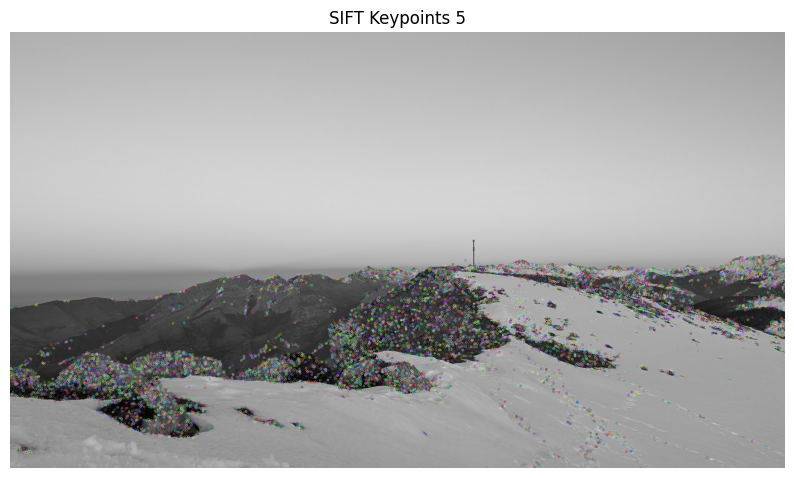

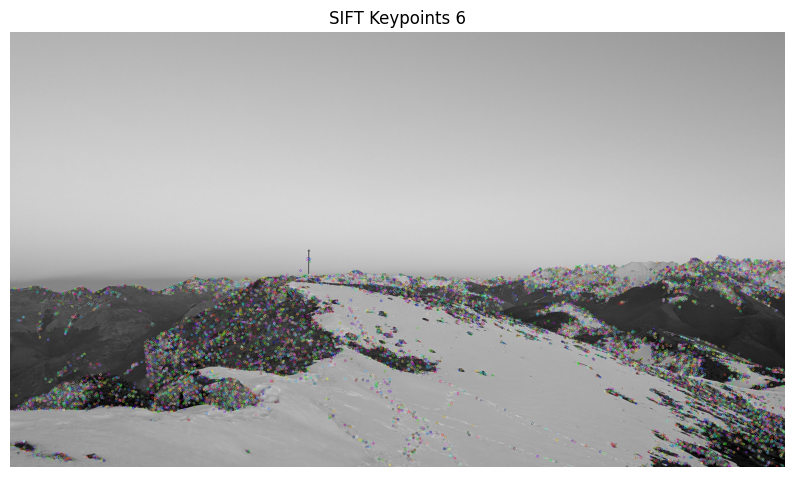

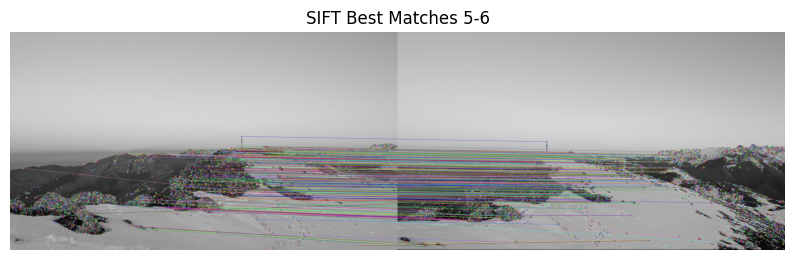

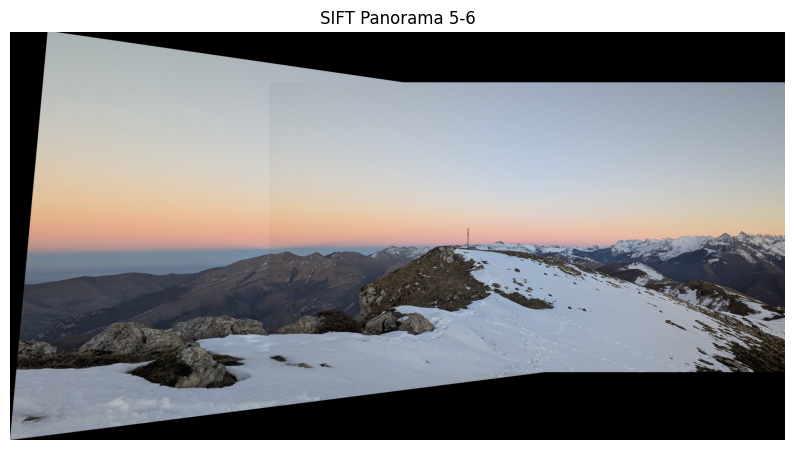

In [8]:
# Load the images
img5, gray5 = load_gray_image("Image_5.png")
img6, gray6 = load_gray_image("Image_6.png")

# Detect SIFT keypoints
sift_kp_5, sift_detector_5 = detect_keypoints(gray5, detector="SIFT", nbKp=0)
sift_kp_6, sift_detector_6 = detect_keypoints(gray6, detector="SIFT", nbKp=0)
img5_sift = cv.drawKeypoints(gray5, sift_kp_5, None)
img6_sift = cv.drawKeypoints(gray6, sift_kp_6, None)
display_image(img5_sift, "SIFT Keypoints 5")
display_image(img6_sift, "SIFT Keypoints 6")

# Compute descriptors for SIFT keypoints
sift_descriptors_5 = compute_descriptors(gray5, sift_kp_5, sift_detector_5)
sift_descriptors_6 = compute_descriptors(gray6, sift_kp_6, sift_detector_6)

# Match SIFT descriptors
sift_best_matches_5_6 = match_keypoints(cv.NORM_L2, sift_descriptors_5, sift_descriptors_6)

# Draw and display SIFT matches
img_sift_matches_5_6 = cv.drawMatches(
    img5_sift, sift_kp_5,
    img6_sift, sift_kp_6,
    sift_best_matches_5_6,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
display_image(img_sift_matches_5_6, "SIFT Best Matches 5-6")

# Compute homography for SIFT matches
sift_H_5_6 = compute_homography(sift_kp_5, sift_kp_6, sift_best_matches_5_6)

# Stitch SIFT images
panorama_sift_5_6 = stitch_images(img5, img6, sift_H_5_6)
display_image(panorama_sift_5_6, "SIFT Panorama 5-6")